In [2]:

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



from scipy import signal
from seiz_eeg.dataset import EEGDataset
from sklearn.model_selection import train_test_split

# Ensure seiz_eeg is installed before importing


import os

# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [3]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "/home/mvukasin/nml_project/data/"

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

# Split the dataset by the 'patient' column
patients = clips_tr['signals_path'].unique()
train_patients, val_patients = train_test_split(patients, test_size=0.2, random_state=42)

# Create training and validation datasets
train_clips = clips_tr[clips_tr['signals_path'].isin(train_patients)]
val_clips = clips_tr[clips_tr['signals_path'].isin(val_patients)]

In [4]:
train_clips.shape, val_clips.shape


((10167, 6), (2826, 6))

## Loading the signals

For convenience, the `EEGDataset class` provides functionality for loading each segment and its label as `numpy` arrays.

You can provide an optional `signal_transform` function to preprocess the signals. In the example below, we have two bandpass filtering functions, which extract frequencies between 0.5Hz and 30Hz which are used in seizure analysis literature:

The `EEGDataset` class also allows to load all data in memory, instead of reading it from disk at every iteration. If your compute allows it, you can use `prefetch=True`.

In [5]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

## Compatibility with PyTorch

The `EEGDataset` class is compatible with [pytorch datasets and dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allow you to load batched data.

In [6]:
# Dependences
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

In [7]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1)

In [8]:
def spectrogram_transform_2d(x: np.ndarray, fs: int = 250, nperseg: int = 64, noverlap: int = 32) -> np.ndarray:
    """
    Compute the log-spectrogram for each channel, output shape: (channels, freq_bins, time_bins)
    """
    x_filt = signal.sosfiltfilt(bp_filter, x, axis=0)
    specs = []
    for ch in range(x_filt.shape[1]):
        f, t, Sxx = signal.spectrogram(x_filt[:, ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
        Sxx_log = np.log(Sxx + 1e-8)
        specs.append(Sxx_log)
    specs = np.stack(specs, axis=0)  # shape: [channels, freq_bins, time_bins]
    return specs.astype(np.float32)


In [9]:
train_dataset = EEGDataset(
        train_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=spectrogram_transform_2d,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

val_dataset = EEGDataset(
        val_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=spectrogram_transform_2d,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

loader_tr = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
loader_val = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

## Baseline: Spectogram features + CNN
The first baseline is a simple CNN model that uses spectrogram features as input. The model is trained on the training set and evaluated on the validation set.


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleEEGCNN(nn.Module):
    def __init__(self, num_channels, freq_bins, time_bins):
        super(SimpleEEGCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=3, padding=1),  # [B,32,F,T]
            nn.ReLU(),
            nn.MaxPool2d(2),  # halve freq/time dims
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # [B,64,F/2,T/2]
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B,64,F/4,T/4]
        )
        
        # Calculate flattened feature size after conv/pool
        fc_input_dim = (freq_bins // 4) * (time_bins // 4) * 64
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc_input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)  # binary output
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x


In [11]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


(19, 33, 92)


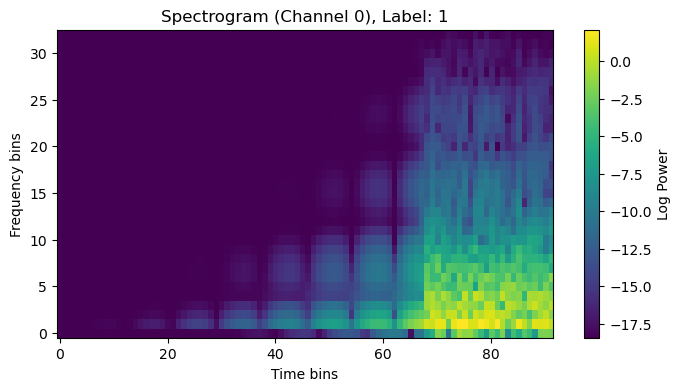

In [12]:
sample = train_dataset[0][0]  # shape: [channels, freq_bins, time_bins]
print(sample.shape)  # e.g., torch.Size([19, 33, 15]) or numpy shape (19, 33, 15)

num_channels = sample.shape[0]
freq_bins = sample.shape[1]
time_bins = sample.shape[2]

# Plot the spectrogram of the first channel of the first sample

sample_x, sample_y = train_dataset[0]  # sample_x shape: [channels, freq_bins, time_bins]
plt.figure(figsize=(8, 4))
plt.imshow(sample_x[0], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Log Power')
plt.title(f"Spectrogram (Channel 0), Label: {sample_y}")
plt.xlabel("Time bins")
plt.ylabel("Frequency bins")
plt.show()





In [13]:
class_weight = 4.0  # Adjust this based on your dataset

model = SimpleEEGCNN(num_channels, freq_bins, time_bins).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [14]:
from sklearn.metrics import f1_score
from tqdm import tqdm  # For progress bar

num_epochs = 50
train_losses = []
val_losses = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in loader_tr:
        x_batch = x_batch.float().to(device)  # [B, C, F, T]
        y_batch = y_batch.float().unsqueeze(1).to(device)  # [B, 1]

        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_batch.size(0)

    avg_loss = running_loss / len(loader_tr.dataset)
    train_losses.append(avg_loss)

    model.eval()
    val_running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for x_val, y_val in loader_val:
            x_val = x_val.float().to(device)  # [B, C, F, T]
            y_val = y_val.float().unsqueeze(1).to(device)  # [B, 1]

            val_logits = model(x_val)
            val_loss = criterion(val_logits, y_val)
            val_running_loss += val_loss.item() * x_val.size(0)

            val_probs = torch.sigmoid(val_logits)
            val_preds = (val_probs > 0.5).int()

            all_labels.extend(y_val.cpu().numpy())
            all_preds.extend(val_preds.cpu().numpy())

    avg_val_loss = val_running_loss / len(loader_val.dataset)
    val_losses.append(avg_val_loss)

    val_f1 = f1_score(all_labels, all_preds, average="macro")
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {avg_loss:.4f} — Val Loss: {avg_val_loss:.4f} — Val F1: {val_f1:.4f}")


Training:   2%|██▊                                                                                                                                          | 1/50 [00:06<05:39,  6.94s/it]

Epoch 1/50 — Train Loss: 1.0013 — Val Loss: 0.8558 — Val F1: 0.6860


Training:   4%|█████▋                                                                                                                                       | 2/50 [00:09<03:20,  4.18s/it]

Epoch 2/50 — Train Loss: 0.7468 — Val Loss: 0.8389 — Val F1: 0.6942


Training:   6%|████████▍                                                                                                                                    | 3/50 [00:11<02:34,  3.29s/it]

Epoch 3/50 — Train Loss: 0.6518 — Val Loss: 0.8650 — Val F1: 0.6810


Training:   8%|███████████▎                                                                                                                                 | 4/50 [00:13<02:12,  2.88s/it]

Epoch 4/50 — Train Loss: 0.6107 — Val Loss: 0.8365 — Val F1: 0.7038


Training:  10%|██████████████                                                                                                                               | 5/50 [00:15<01:59,  2.65s/it]

Epoch 5/50 — Train Loss: 0.5504 — Val Loss: 1.0142 — Val F1: 0.6986


Training:  12%|████████████████▉                                                                                                                            | 6/50 [00:18<01:50,  2.52s/it]

Epoch 6/50 — Train Loss: 0.5118 — Val Loss: 0.9439 — Val F1: 0.6959


Training:  14%|███████████████████▋                                                                                                                         | 7/50 [00:20<01:44,  2.43s/it]

Epoch 7/50 — Train Loss: 0.4750 — Val Loss: 0.9052 — Val F1: 0.7142


Training:  16%|██████████████████████▌                                                                                                                      | 8/50 [00:22<01:39,  2.38s/it]

Epoch 8/50 — Train Loss: 0.4538 — Val Loss: 1.0583 — Val F1: 0.7330


Training:  18%|█████████████████████████▍                                                                                                                   | 9/50 [00:24<01:35,  2.34s/it]

Epoch 9/50 — Train Loss: 0.4241 — Val Loss: 0.8922 — Val F1: 0.7025


Training:  20%|████████████████████████████                                                                                                                | 10/50 [00:27<01:32,  2.31s/it]

Epoch 10/50 — Train Loss: 0.4175 — Val Loss: 0.8798 — Val F1: 0.7340


Training:  22%|██████████████████████████████▊                                                                                                             | 11/50 [00:29<01:29,  2.30s/it]

Epoch 11/50 — Train Loss: 0.3722 — Val Loss: 1.0636 — Val F1: 0.7276


Training:  24%|█████████████████████████████████▌                                                                                                          | 12/50 [00:31<01:26,  2.28s/it]

Epoch 12/50 — Train Loss: 0.3480 — Val Loss: 0.8269 — Val F1: 0.7133


Training:  26%|████████████████████████████████████▍                                                                                                       | 13/50 [00:33<01:24,  2.28s/it]

Epoch 13/50 — Train Loss: 0.3164 — Val Loss: 1.1104 — Val F1: 0.6867


Training:  28%|███████████████████████████████████████▏                                                                                                    | 14/50 [00:36<01:21,  2.27s/it]

Epoch 14/50 — Train Loss: 0.2868 — Val Loss: 1.1557 — Val F1: 0.7239


Training:  30%|██████████████████████████████████████████                                                                                                  | 15/50 [00:38<01:19,  2.27s/it]

Epoch 15/50 — Train Loss: 0.2710 — Val Loss: 1.2635 — Val F1: 0.7272


Training:  32%|████████████████████████████████████████████▊                                                                                               | 16/50 [00:40<01:17,  2.28s/it]

Epoch 16/50 — Train Loss: 0.2324 — Val Loss: 1.2152 — Val F1: 0.6776


Training:  34%|███████████████████████████████████████████████▌                                                                                            | 17/50 [00:43<01:15,  2.28s/it]

Epoch 17/50 — Train Loss: 0.2152 — Val Loss: 1.3688 — Val F1: 0.7015


Training:  36%|██████████████████████████████████████████████████▍                                                                                         | 18/50 [00:45<01:12,  2.27s/it]

Epoch 18/50 — Train Loss: 0.1833 — Val Loss: 1.3711 — Val F1: 0.7226


Training:  38%|█████████████████████████████████████████████████████▏                                                                                      | 19/50 [00:47<01:10,  2.27s/it]

Epoch 19/50 — Train Loss: 0.1632 — Val Loss: 1.5524 — Val F1: 0.7135


Training:  40%|████████████████████████████████████████████████████████                                                                                    | 20/50 [00:49<01:07,  2.26s/it]

Epoch 20/50 — Train Loss: 0.1363 — Val Loss: 1.5355 — Val F1: 0.7284


Training:  42%|██████████████████████████████████████████████████████████▊                                                                                 | 21/50 [00:52<01:05,  2.26s/it]

Epoch 21/50 — Train Loss: 0.1493 — Val Loss: 2.0535 — Val F1: 0.7235


Training:  44%|█████████████████████████████████████████████████████████████▌                                                                              | 22/50 [00:54<01:03,  2.26s/it]

Epoch 22/50 — Train Loss: 0.1112 — Val Loss: 2.1874 — Val F1: 0.7124


Training:  46%|████████████████████████████████████████████████████████████████▍                                                                           | 23/50 [00:56<01:01,  2.26s/it]

Epoch 23/50 — Train Loss: 0.0949 — Val Loss: 2.4289 — Val F1: 0.7111


Training:  48%|███████████████████████████████████████████████████████████████████▏                                                                        | 24/50 [00:58<00:58,  2.26s/it]

Epoch 24/50 — Train Loss: 0.1170 — Val Loss: 2.6039 — Val F1: 0.6984


Training:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 25/50 [01:01<00:56,  2.26s/it]

Epoch 25/50 — Train Loss: 0.1110 — Val Loss: 3.1522 — Val F1: 0.6985


Training:  52%|████████████████████████████████████████████████████████████████████████▊                                                                   | 26/50 [01:03<00:54,  2.27s/it]

Epoch 26/50 — Train Loss: 0.1576 — Val Loss: 2.2172 — Val F1: 0.7139


Training:  54%|███████████████████████████████████████████████████████████████████████████▌                                                                | 27/50 [01:05<00:52,  2.27s/it]

Epoch 27/50 — Train Loss: 0.0933 — Val Loss: 1.9081 — Val F1: 0.7170


Training:  56%|██████████████████████████████████████████████████████████████████████████████▍                                                             | 28/50 [01:07<00:49,  2.27s/it]

Epoch 28/50 — Train Loss: 0.0715 — Val Loss: 2.5237 — Val F1: 0.7424


Training:  58%|█████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/50 [01:10<00:47,  2.27s/it]

Epoch 29/50 — Train Loss: 0.0514 — Val Loss: 1.9885 — Val F1: 0.7104


Training:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 30/50 [01:12<00:45,  2.27s/it]

Epoch 30/50 — Train Loss: 0.0510 — Val Loss: 2.5777 — Val F1: 0.7449


Training:  62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                     | 31/50 [01:14<00:43,  2.26s/it]

Epoch 31/50 — Train Loss: 0.0440 — Val Loss: 2.9217 — Val F1: 0.7194


Training:  64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 32/50 [01:17<00:40,  2.27s/it]

Epoch 32/50 — Train Loss: 0.0757 — Val Loss: 3.0938 — Val F1: 0.7002


Training:  66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 33/50 [01:19<00:38,  2.27s/it]

Epoch 33/50 — Train Loss: 0.1009 — Val Loss: 2.6408 — Val F1: 0.7392


Training:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 34/50 [01:21<00:36,  2.27s/it]

Epoch 34/50 — Train Loss: 0.0900 — Val Loss: 2.8079 — Val F1: 0.7397


Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 35/50 [01:23<00:34,  2.27s/it]

Epoch 35/50 — Train Loss: 0.0356 — Val Loss: 3.4914 — Val F1: 0.7283


Training:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 36/50 [01:26<00:31,  2.28s/it]

Epoch 36/50 — Train Loss: 0.0353 — Val Loss: 3.1741 — Val F1: 0.7314


Training:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 37/50 [01:28<00:29,  2.28s/it]

Epoch 37/50 — Train Loss: 0.0281 — Val Loss: 3.3040 — Val F1: 0.7165


Training:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 38/50 [01:30<00:27,  2.28s/it]

Epoch 38/50 — Train Loss: 0.0361 — Val Loss: 3.3250 — Val F1: 0.7347


Training:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 39/50 [01:33<00:25,  2.28s/it]

Epoch 39/50 — Train Loss: 0.0771 — Val Loss: 3.7636 — Val F1: 0.7075


Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 40/50 [01:35<00:22,  2.28s/it]

Epoch 40/50 — Train Loss: 0.0455 — Val Loss: 3.4870 — Val F1: 0.6939


Training:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 41/50 [01:37<00:20,  2.28s/it]

Epoch 41/50 — Train Loss: 0.0568 — Val Loss: 3.3492 — Val F1: 0.7347


Training:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 42/50 [01:39<00:18,  2.28s/it]

Epoch 42/50 — Train Loss: 0.0278 — Val Loss: 3.6460 — Val F1: 0.7287


Training:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 43/50 [01:42<00:15,  2.28s/it]

Epoch 43/50 — Train Loss: 0.0337 — Val Loss: 4.0777 — Val F1: 0.7235


Training:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 44/50 [01:44<00:13,  2.28s/it]

Epoch 44/50 — Train Loss: 0.0706 — Val Loss: 2.8072 — Val F1: 0.7251


Training:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 45/50 [01:46<00:11,  2.28s/it]

Epoch 45/50 — Train Loss: 0.0382 — Val Loss: 4.1463 — Val F1: 0.7295


Training:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 46/50 [01:48<00:09,  2.27s/it]

Epoch 46/50 — Train Loss: 0.0551 — Val Loss: 3.1532 — Val F1: 0.7089


Training:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 47/50 [01:51<00:06,  2.27s/it]

Epoch 47/50 — Train Loss: 0.0128 — Val Loss: 3.4990 — Val F1: 0.7328


Training:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 48/50 [01:53<00:04,  2.27s/it]

Epoch 48/50 — Train Loss: 0.0230 — Val Loss: 3.3205 — Val F1: 0.7328


Training:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 49/50 [01:55<00:02,  2.27s/it]

Epoch 49/50 — Train Loss: 0.0143 — Val Loss: 3.5922 — Val F1: 0.7180


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:58<00:00,  2.36s/it]

Epoch 50/50 — Train Loss: 0.0679 — Val Loss: 2.5787 — Val F1: 0.7236


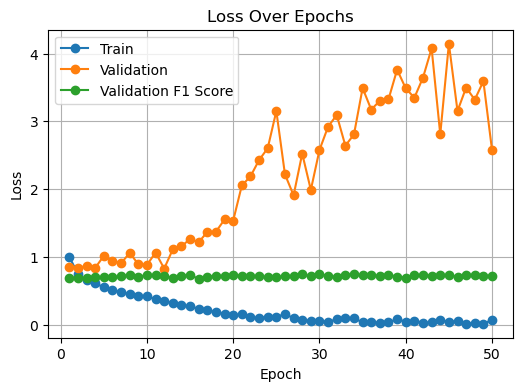

In [15]:
# Plot the training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_f1_scores, marker="o")
plt.title("Loss Over Epochs")
plt.legend(["Train", "Validation", "Validation F1 Score"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [19]:
from evaluation import evaluate

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

class_weight = 4
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))

# check if the it using gpu
if torch.cuda.is_available():
    print("Using GPU for evaluation")
else:
    print("Using CPU for evaluation")

evaluate(
    SimpleEEGCNN,
    clips_tr,
    signals_root=DATA_ROOT / "train",
    num_epochs=15,
    learning_rate=1e-3,
    model_args={
        "num_channels": num_channels,
        "freq_bins": freq_bins,
        "time_bins": time_bins,
    },
    criterion=criterion,
    signal_transform=spectrogram_transform_2d,
    batch_size=256,  # Reduce batch size to avoid OOM
    prefetch=True, # Set to False if you still get OOM
)

Using GPU for evaluation
Fold 1/5
Fold 1 F1 Score: 0.7205
Fold 2/5
Fold 2 F1 Score: 0.7713
Fold 3/5
Fold 3 F1 Score: 0.7896
Fold 4/5
Fold 4 F1 Score: 0.7109
Fold 5/5
Fold 5 F1 Score: 0.7227
Cross-Validation Average F1 Score: 0.7430
Cross-Validation F1 Score Standard Deviation: 0.0314


(0.7430109732363096, 0.03135709464474608)

# Submission

In [ ]:
test_clips = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

In [ ]:
# Create test dataset
dataset_te = EEGDataset(
    test_clips,
    signals_root=DATA_ROOT / "test",
    signal_transform=spectrogram_transform_2d,  # Use the same transform
    prefetch=True,
    return_id=True,
)

# Create DataLoader for the test dataset
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

In [ ]:
# Generate the submission file for Kaggle

# Set the model to evaluation mode
model.eval()

# Lists to store sample IDs and predictions
all_predictions = []
all_ids = []

# Disable gradient computation for inference
with torch.no_grad():
    for batch in loader_te:
        # Assume each batch returns a tuple (x_batch, sample_id)
        # If your dataset does not provide IDs, you can generate them based on the batch index.
        x_batch, x_ids = batch

        # Move the input data to the device (GPU or CPU)
        x_batch = x_batch.float().to(device)

        # Perform the forward pass to get the model's output logits
        logits = model(x_batch)

        # Convert logits to predictions.
        # For binary classification, threshold logits at 0 (adjust this if you use softmax or multi-class).
        predictions = (logits > 0).int().cpu().numpy()

        # Append predictions and corresponding IDs to the lists
        all_predictions.extend(predictions.flatten().tolist())
        all_ids.extend(list(x_ids))

# Create a DataFrame for Kaggle submission with the required format: "id,label"
submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})

# Save the DataFrame to a CSV file without an index
submission_df.to_csv("submission_seed2.csv", index=False)
print("Kaggle submission file generated: submission.csv")

Kaggle submission file generated: submission.csv
